# Program - pyrecdctanimation
Using Pyaudio, record sound from the audio device and plot the dct magnitude spectrum life, for 8 seconds.<br/>
Usage example: python pyrecdctanimation.py<br/>
Gerald Schuller, November 2014

* Import the relevant modules.

In [1]:
import pyaudio
import struct
import numpy as np
import scipy.fftpack
import matplotlib.pyplot as plt
import matplotlib.animation as animation

* Define the variables.

In [2]:
CHUNK = 2048 #Blocksize
WIDTH = 2 #2 bytes per sample
CHANNELS = 1 #2
RATE = 32000  #Sampling Rate in Hz
RECORD_SECONDS = 70

dctlen=CHUNK/2

* Plot animation setup.

In [3]:
[fig, ax] = plt.subplots()
plt.ylabel('dB')
plt.xlabel('DCT Type 2 bins/Subbands')
plt.title('Live DCT Type 2 Magnitude Spectrum of Microphone Signal')

In [4]:
x = np.arange(0, dctlen)        # x-array

* Set scale on y-axis and generate line object with it:

In [5]:
[line, ]= ax.plot(x, 100.0**np.sin(x))

* FUnction to produce the animation.

In [6]:
def animate(i):
    # update the data
    #Reading from audio input stream into data with block length "CHUNK":
    data = stream.read(CHUNK)
    #Convert from stream of bytes to a list of short integers (2 bytes here) in "samples":
    #shorts = (struct.unpack( "128h", data ))
    shorts = (struct.unpack( 'h' * CHUNK, data ));
    samples=np.array(list(shorts),dtype=float);

    #plt.plot(samples)  #<-- here goes the signal processing.
    line.set_ydata(20.0*np.log10((np.abs(scipy.fftpack.dct(samples[0:dctlen])/np.sqrt(dctlen))+1)))
    #line.set_ydata(samples)
    return line,

* Initialization function.

In [7]:
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

* Initialise audio port and print out its information.

In [8]:
p = pyaudio.PyAudio()

a = p.get_device_count()
print("device count=",a)

for i in range(0, a):
    print("i = ",i)
    b = p.get_device_info_by_index(i)['maxInputChannels']
    print(b)
    b = p.get_device_info_by_index(i)['defaultSampleRate']
    print(b)

('device count=', 10L)
('i = ', 0)
2
44100.0
('i = ', 1)
0
44100.0
('i = ', 2)
128
48000.0
('i = ', 3)
0
44100.0
('i = ', 4)
0
44100.0
('i = ', 5)
0
44100.0
('i = ', 6)
0
44100.0
('i = ', 7)
32
44100.0
('i = ', 8)
0
48000.0
('i = ', 9)
32
44100.0


* Initialise a stream to work with the audio port and set its parameters.

* recording


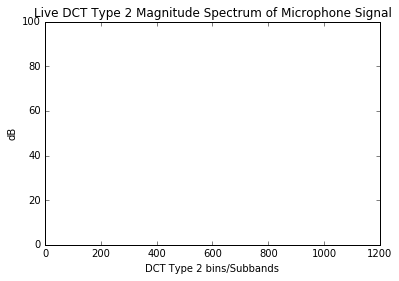

In [9]:
stream = p.open(format=p.get_format_from_width(WIDTH),
                channels=CHANNELS,
                rate=RATE,
                input=True,
                output=True,
                #input_device_index=3,
                frames_per_buffer=CHUNK)

print("* recording")

ani = animation.FuncAnimation(fig, animate,  init_func=init, interval=25, blit=True)
plt.show()

* When everything done, release the capture.

In [10]:
print("* done")

#f.close()
stream.stop_stream()
stream.close()

* done


**Note**: To see the live plot run the program by following command:
        
        python pyrecdctanimation

---

# Program - videorecdct0idctdisp
Program to capture a video from the default camera (0), compute the 2D FFT on the Green component, take the magnitude (phase) and display it live on the screen apply a 2D DCT , low pass filter, and iverse transform.<br/>
Gerald Schuller, Nov. 2014

In [ ]:
import cv2
import numpy as np
import scipy.fftpack as sft

cap = cv2.VideoCapture(0)

* Get size of frame:

In [ ]:
[retval, frame] = cap.read()
[r,c,d]=frame.shape
print(r,c)

* Mask to set to zero the 3/4 highest frequencies, only kep the 1/4 lowest frequencies in each direction for the DCT, because of the DCT no longer symmetric about the center:

In [ ]:
#For rows:
Mr = np.ones((r,1))
Mr[(r/4.0):r,0] = np.zeros((3.0/4.0*r))
#For columns:
Mc = np.ones((1,c))
Mc[0,(c/4.0):c] = np.zeros((3.0/4.0*c));
#Together:
M = np.dot(Mr,Mc)

In [ ]:
while(True):
    # Capture frame-by-frame
    [retval, frame] = cap.read()
    cv2.imshow('Original Video, Gruen Komponente',frame[:,:,1])

    #compute magnitude of 2D DCT of green component
    #with suitable normalization for the display,
    #with norm='ortho' for "energy conservation" in the subbands and for
    #invertibiltity without factor:
    X=sft.dct(frame[:,:,1]/255.0,axis=1,norm='ortho')
    X=sft.dct(X,axis=0,norm='ortho')
    #Set to zero the 7/8 highest spacial frequencies in each direction:
    X=X*M
    frame=np.abs(X)

    # Display the resulting frame
    cv2.imshow('2D-DCT mit Null Setzen der hoechsten Ortsfrequenzen',frame)
    #Inverse 2D DCT:
    X=sft.idct(X,axis=1,norm='ortho')
    x=sft.idct(X,axis=0,norm='ortho')
    cv2.imshow('Inverse 2D DCT ohne die hoechsten Ortsfrequenzen', x)

    #Keep window open until key 'q' is pressed:
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

* When everything done, release the capture

In [ ]:
cap.release()
cv2.destroyAllWindows()

---

# Program - videorecdctblocks0idctdisp
Program to capture a video from the default camera (0), compute the 2D DCT on the Green component, take the magnitude (phase) and display it live on the screen, divide the picture into blocks of 8x8 pixels and apply a 2D DCT to each, low pass filter, and inverse transform.<br/>
Gerald Schuller, Nov. 2014

In [ ]:
import cv2
import numpy as np
import scipy.fftpack as sft

cap = cv2.VideoCapture(0)

* Get size of frame:

In [ ]:
[retval, frame] = cap.read()
[r,c,d]=frame.shape
print(r,c)

* Mask to set to zero the 3/4 highest frequencies, only kep the 1/4 lowest frequencies in each direction for the 8x8 DCT, because of the DCT no longer symmetric about the center:

In [ ]:
#For rows:
Mr=np.ones(8) 
Mr[(8/4.0):r]=np.zeros((3.0/4.0*8))
#For columns:
Mc=Mr;

#Grid of 8x8 blocks:
gc=np.zeros((1,c))
gc[0,0:c:8]=np.ones(c/8)
gr=np.zeros((r,1))
gr[0:r:8,0]=np.ones(r/8)
grid=np.ones((r,1))*gc+gr*np.ones((1,c))
#print(grid[0:9,0:9])

In [ ]:
while(True):
    # Capture frame-by-frame
    [retval, frame] = cap.read()    

    cv2.imshow('Original Video, Gruen Komponente',frame[:,:,1]/255.0+grid)
    #cv2.imshow('Original Video, Gruen Komponente',frame[:,:,1])

    #compute magnitude of 2D DCT of blocks of 8x8 pixels of the green component 
    #by first reshaping the image to width 8 and applying the 1D DCT all rows, then reshape it back,
    #then transpose it, and again reshape it to width 8 and apply the 1D DCT to each row, reshape it back,
    #and transpose it back.
    #with norm='ortho' for "energy conservation" in the subbands and for 
    #invertibiltity without factor.

    #First reshape green frame as frame with rows of width 8, (rows: order= 'C' ), 
    #and apply DCT to each row of length 8 of all blocks:
    frame=np.reshape(frame[:,:,1],(-1,8), order='C')
    X=sft.dct(frame/255.0,axis=1,norm='ortho')
    #apply row filter to each row by matrix multiplication with Mr as a diagonal matrix from the right:
    X=np.dot(X,np.diag(Mr))
    #shape it back to original shape:
    X=np.reshape(X,(-1,c), order='C')
    #Shape frame with columns of hight 8 by using transposition .T:
    X=np.reshape(X.T,(-1,8), order='C')
    X=sft.dct(X,axis=1,norm='ortho')
    #apply column filter to each row by matrix multiplication with Mc as a diagonal matrix from the right:
    X=np.dot(X,np.diag(Mc))
    #shape it back to original shape:
    X=(np.reshape(X,(-1,r), order='C')).T
    #Set to zero the 7/8 highest spacial frequencies in each direction:
    #X=X*M
    frame=np.abs(X)
    
    # Display the resulting frame
    cv2.imshow('2D-DCT mit Null Setzen der hoechsten Ortsfrequenzen je 8x8 Block',frame)
    #Inverse 2D DCT,
    #Rows:
    X=np.reshape(X,(-1,8), order='C')
    X=sft.idct(X,axis=1,norm='ortho')
    #shape it back to original shape:
    X=np.reshape(X,(-1,c), order='C')
    #Shape frame with columns of hight 8 (columns: order='F' convention):
    X=np.reshape(X.T,(-1,8), order='C')
    x=sft.idct(X,axis=1,norm='ortho')
    #shape it back to original shape:
    x=(np.reshape(x,(-1,r), order='C')).T 
 
    cv2.imshow('Inverse 2D DCT ohne die hoechsten Ortsfrequenzen', x)
    
    #Keep window open until key 'q' is pressed:
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

* When everything done, release the capture

In [ ]:
cap.release()
cv2.destroyAllWindows()

---

# Program - videorecdctdisp
Program to capture a video from the default camera (0), compute the 2D DCT Type 2 on the Green component, take the magnitude (phase) and display it live on the screen.<br/>
Gerald Schuller, Nov. 2014

In [ ]:
import cv2
import numpy as np
import scipy.fftpack as sft

cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    [retval, frame] = cap.read()    
    #compute magnitude of 2D DCT of green component 
    #by applying the DCT first along the rows and the along the columns,
    #with suitable normalization for the display:
    frame=sft.dct(frame[:,:,1]/255.0,axis=1,norm='ortho')
    frame=np.abs(sft.dct(frame,axis=0,norm='ortho'))
    #angle/phase:
    #frame=(3.14+np.angle(np.fft.fft2(frame[:,:,1]/255.0)))/6.28
    # Display the resulting frame
    cv2.imshow('Betrag der 2D - DCT Typ 2 des Videos',frame)
    #Keep window open until key 'q' is pressed:
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

* When everything done, release the capture

In [ ]:
cap.release()
cv2.destroyAllWindows()